In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models

In [ ]:
IMG_DIR = '/content/drive/MyDrive/archive (1)/Training'
IMG_SIZE = 128
BATCH_SIZE = 8
EPOCHS = 2

In [ ]:
def load_images_and_masks(base_dir, img_size):
    images = []
    masks = []
    for label in os.listdir(base_dir):
        class_path = os.path.join(base_dir, label)
        for fname in os.listdir(class_path):
            fpath = os.path.join(class_path, fname)

            # Load and preprocess image
            img = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (img_size, img_size))
            img = img.astype('float32') / 255.0
            images.append(img)

            # Generate fake mask
            mask = np.zeros((img_size, img_size), dtype=np.uint8)
            if 'no' not in label.lower():  # Only add fake tumor if not "no"
                cx, cy = np.random.randint(20, img_size - 20, size=2)
                radius = np.random.randint(10, 20)
                cv2.circle(mask, (cx, cy), radius, 255, -1)  # use 255 instead of 1

            masks.append(mask)

    images = np.expand_dims(np.array(images), axis=-1)
    masks = np.expand_dims(np.array(masks), axis=-1).astype('float32') / 255.0  # normalize mask
    return images, masks

In [ ]:
# Load data
images, masks = load_images_and_masks(IMG_DIR, IMG_SIZE)
print(f"Loaded {len(images)} images.")

Loaded 5712 images.


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(images, masks, test_size=0.2, random_state=42)

In [ ]:
def unet_model(input_size=(IMG_SIZE, IMG_SIZE, 1)):
    inputs = layers.Input(input_size)

    def conv_block(x, filters):
        x = layers.Conv2D(filters, 3, activation='relu', padding='same')(x)
        x = layers.Conv2D(filters, 3, activation='relu', padding='same')(x)
        return x

    def encoder_block(x, filters):
        f = conv_block(x, filters)
        p = layers.MaxPooling2D()(f)
        return f, p

    def decoder_block(x, skip, filters):
        x = layers.Conv2DTranspose(filters, 2, strides=2, padding='same')(x)
        x = layers.Concatenate()([x, skip])
        x = conv_block(x, filters)
        return x

    f1, p1 = encoder_block(inputs, 64)
    f2, p2 = encoder_block(p1, 128)
    f3, p3 = encoder_block(p2, 256)
    f4, p4 = encoder_block(p3, 512)

    bottleneck = conv_block(p4, 1024)

    d1 = decoder_block(bottleneck, f4, 512)
    d2 = decoder_block(d1, f3, 256)
    d3 = decoder_block(d2, f2, 128)
    d4 = decoder_block(d3, f1, 64)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(d4)

    return models.Model(inputs, outputs)


In [ ]:
model = unet_model()

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 512) │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 8, 8,      │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 8, 8,      │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 16, 16,    │  2,097,664 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 16, 16,    │          0 │ conv2d_transpose

 Total params: 31,030,593 (118.37 MB)

 Trainable params: 31,030,593 (118.37 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, Y_train, validation_split=0.1, epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/2
514/514 ━━━━━━━━━━━━━━━━━━━━ 8074s 16s/step - accuracy: 0.9690 - loss: 0.1769 - val_accuracy: 0.9696 - val_loss: 0.1257
Epoch 2/2
514/514 ━━━━━━━━━━━━━━━━━━━━ 8170s 16s/step - accuracy: 0.9702 - loss: 0.1255 - val_accuracy: 0.9696 - val_loss: 0.1268


In [ ]:
def show_predictions(images, masks, preds, num=5):
    for i in range(num):
        fig, axs = plt.subplots(1, 3, figsize=(12, 4))
        axs[0].imshow(images[i].squeeze(), cmap='gray')
        axs[0].set_title("Input MRI")
        axs[1].imshow(masks[i].squeeze(), cmap='gray')
        axs[1].set_title("True Mask")
        axs[2].imshow(preds[i].squeeze(), cmap='gray')
        axs[2].set_title("Predicted Mask")
        plt.show()

36/36 ━━━━━━━━━━━━━━━━━━━━ 601s 17s/step


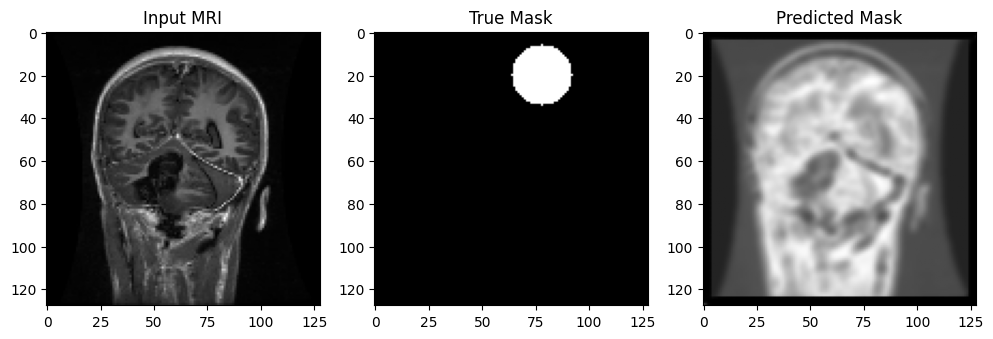

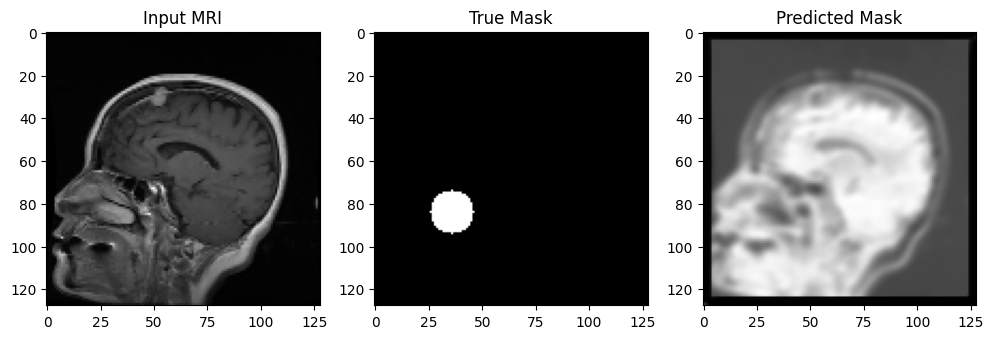

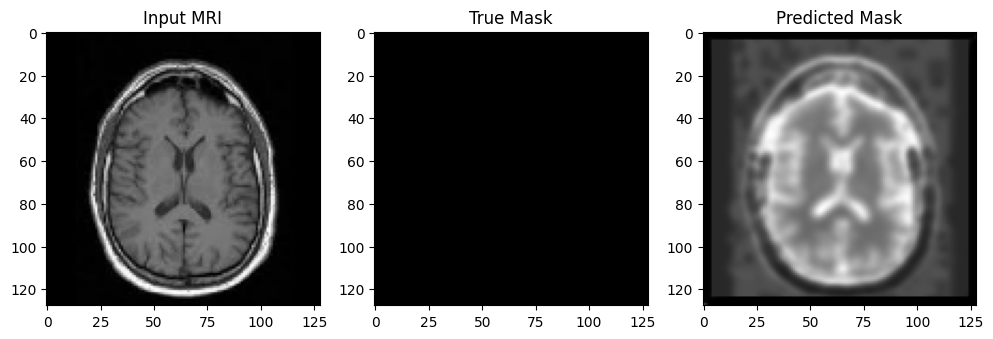

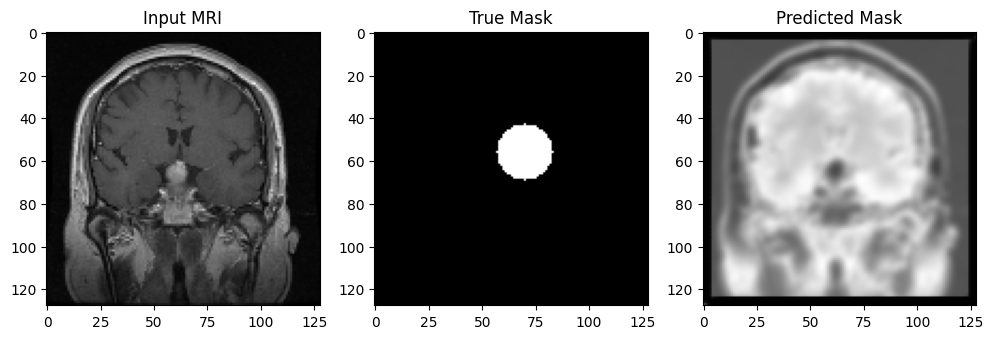

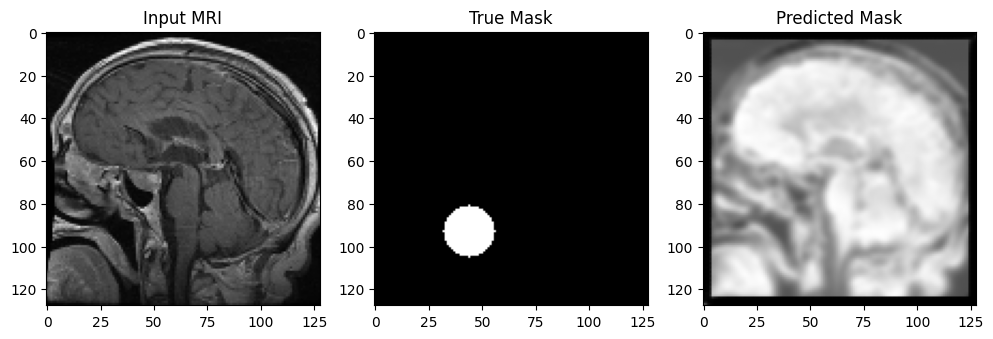

In [ ]:
# Predict and visualize
preds = model.predict(X_test)
show_predictions(X_test, Y_test, preds)

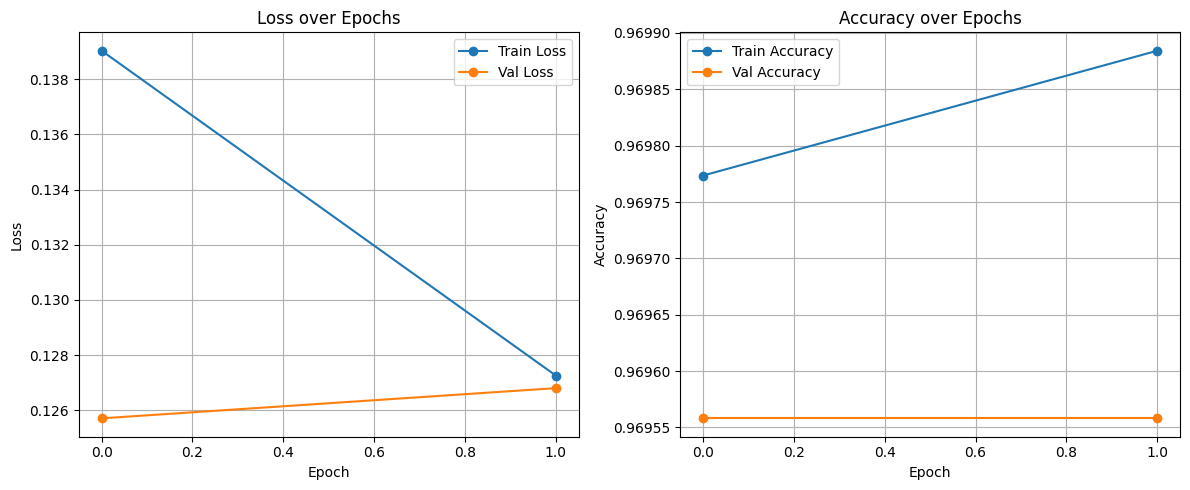

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy (optional, only if you tracked it)
if 'accuracy' in history.history:
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


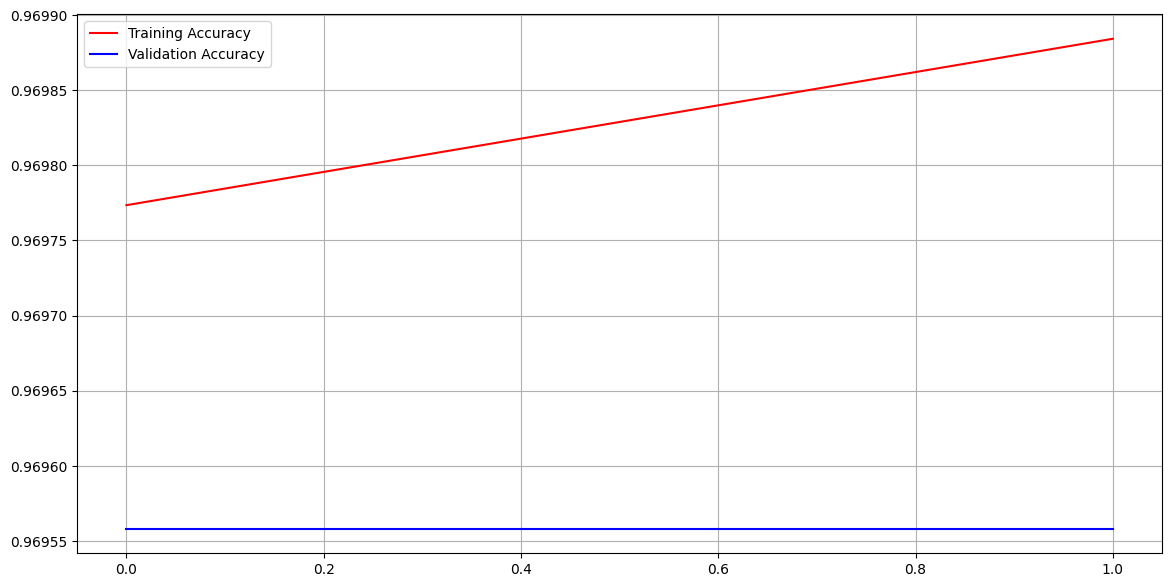

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

fig = plt.figure(figsize=(14,7))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [ ]:
os.makedirs("models", exist_ok=True)

In [ ]:
model.save("models/segmentation_model.keras")

In [ ]:
from google.colab import files
files.download('/content/models/segmentation_model.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>